In [211]:
# basics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# penny
import pennylane as qml
from pennylane.transforms import compile
from pennylane.math import fidelity_statevector as fidelity_penny
# qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Gate
from qiskit_aer import Aer
from qiskit.visualization import plot_circuit_layout, circuit_drawer
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector, state_fidelity
from math import pi

In [208]:
# Create a bloated circuit with 4 qubits
qc = QuantumCircuit(4)

# Redundant gates and inefficient layout
qc.h(0)
qc.h(0)  # Cancels out with previous H
qc.cx(0, 1)
qc.cx(1, 0)  # Reversible CX pair
qc.swap(0, 2)
qc.swap(2, 0)  # Double swap = identity
qc.rx(0.5, 3)
qc.rx(-0.5, 3)  # Cancels out
qc.rz(0.25, 1)
qc.rz(0.25, 1)  # Can be merged
qc.cx(2, 3)
qc.cx(3, 2)  # Reversible again
# qc.measure_all()

ref_state = Statevector(qc)

In [149]:
qc.draw()

┌───┐      ┌───┐         ┌───┐                                   
q_0: ───┤ H ├──────┤ H ├──────■──┤ X ├─X──────────────X──────────────────
        └───┘      └───┘    ┌─┴─┐└─┬─┘ │ ┌──────────┐ │ ┌──────────┐     
q_1: ───────────────────────┤ X ├──■───┼─┤ Rz(0.25) ├─┼─┤ Rz(0.25) ├─────
                            └───┘      │ └──────────┘ │ └──────────┘┌───┐
q_2: ──────────────────────────────────X──────────────X──────■──────┤ X ├
     ┌─────────┐┌──────────┐                               ┌─┴─┐    └─┬─┘
q_3: ┤ Rx(0.5) ├┤ Rx(-0.5) ├───────────────────────────────┤ X ├──────■──
     └─────────┘└──────────┘                               └───┘

In [212]:
def summary_qiskit(qc):
    counts = {"1-qubit": 0, "2-qubit": 0}
    for inst in qc.data:
        if isinstance(inst.operation, Gate):  # Skip measurements and non-gates
            num_qubits = len(inst.qubits)
            if num_qubits == 1:
                counts["1-qubit"] += 1
            elif num_qubits == 2:
                counts["2-qubit"] += 1
    return [qc.num_qubits, qc.size(), counts['1-qubit'], counts['2-qubit'], qc.depth()]

In [152]:
summary_qiskit(qc)

[4, 12, 6, 6, 8]

In [172]:
# Transpile with qiskit
qc.save_statevector()
backend = Aer.get_backend('qasm_simulator')
transpiled_qiskit_2 = transpile(qc, backend)
result_2 = backend.run(transpiled_qiskit_2).result()
qiskit_2_state = result_2.get_statevector()
print(qiskit_2_state)

Statevector([0.96891242-0.24740396j, 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ],
            dims=(2, 2, 2, 2))


In [35]:
transpiled_qiskit_2.draw()

global phase: 6.0332
             ┌───┐                            ░ ┌─┐         
   q_0: ──■──┤ X ├────────────X──X────────────░─┤M├─────────
        ┌─┴─┐└─┬─┘┌─────────┐ │  │            ░ └╥┘┌─┐      
   q_1: ┤ X ├──■──┤ U1(0.5) ├─┼──┼────────────░──╫─┤M├──────
        └───┘     └─────────┘ │  │      ┌───┐ ░  ║ └╥┘┌─┐   
   q_2: ──────────────────────X──X───■──┤ X ├─░──╫──╫─┤M├───
                                   ┌─┴─┐└─┬─┘ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────────────────┤ X ├──■───░──╫──╫──╫─┤M├
                                   └───┘      ░  ║  ║  ║ └╥┘
meas: 4/═════════════════════════════════════════╩══╩══╩══╩═
                                                 0  1  2  3

In [173]:
# Transpile with qiskit
backend = Aer.get_backend('qasm_simulator')
transpiled_qiskit_3 = transpile(qc, backend, optimization_level=3)
result_3 = backend.run(transpiled_qiskit_3).result()
qiskit_3_state = result_3.get_statevector()
print(qiskit_3_state)

Statevector([0.96891242-0.24740396j, 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ],
            dims=(2, 2, 2, 2))


Matplotlib is building the font cache; this may take a moment.


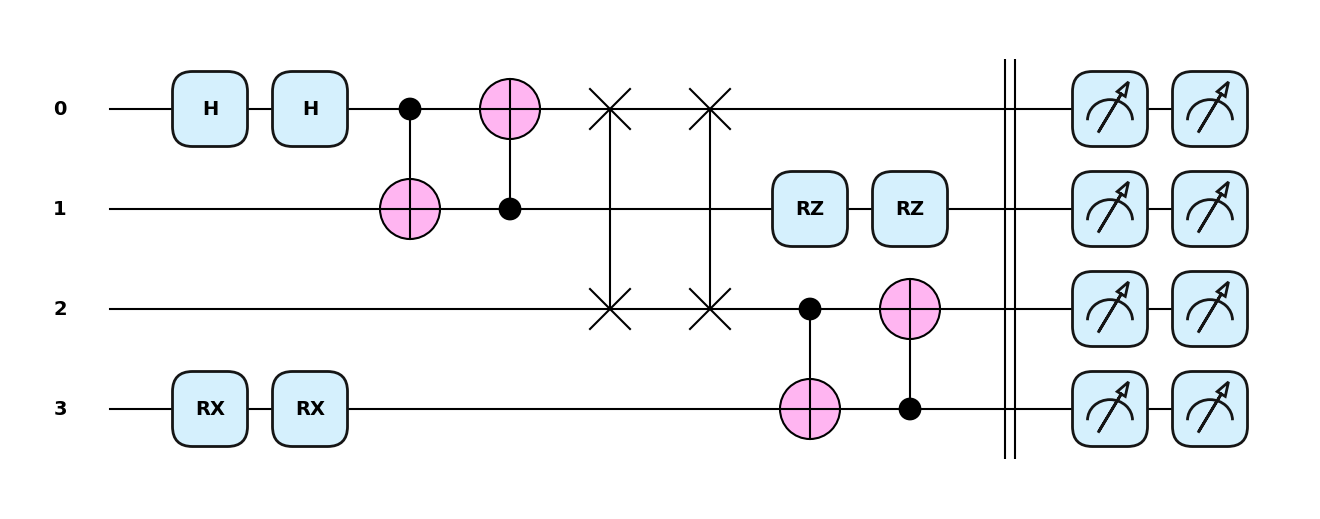

In [88]:
pc_penny = qml.from_qiskit(qc)
num_q = qc.num_qubits
dev = qml.device("default.qubit", wires=num_q)

@qml.qnode(dev)
def circuit():
    pc_penny(wires=range(num_q))
    return qml.state()

qml.draw_mpl(circuit, style='pennylane')()
plt.show()

Matplotlib is building the font cache; this may take a moment.


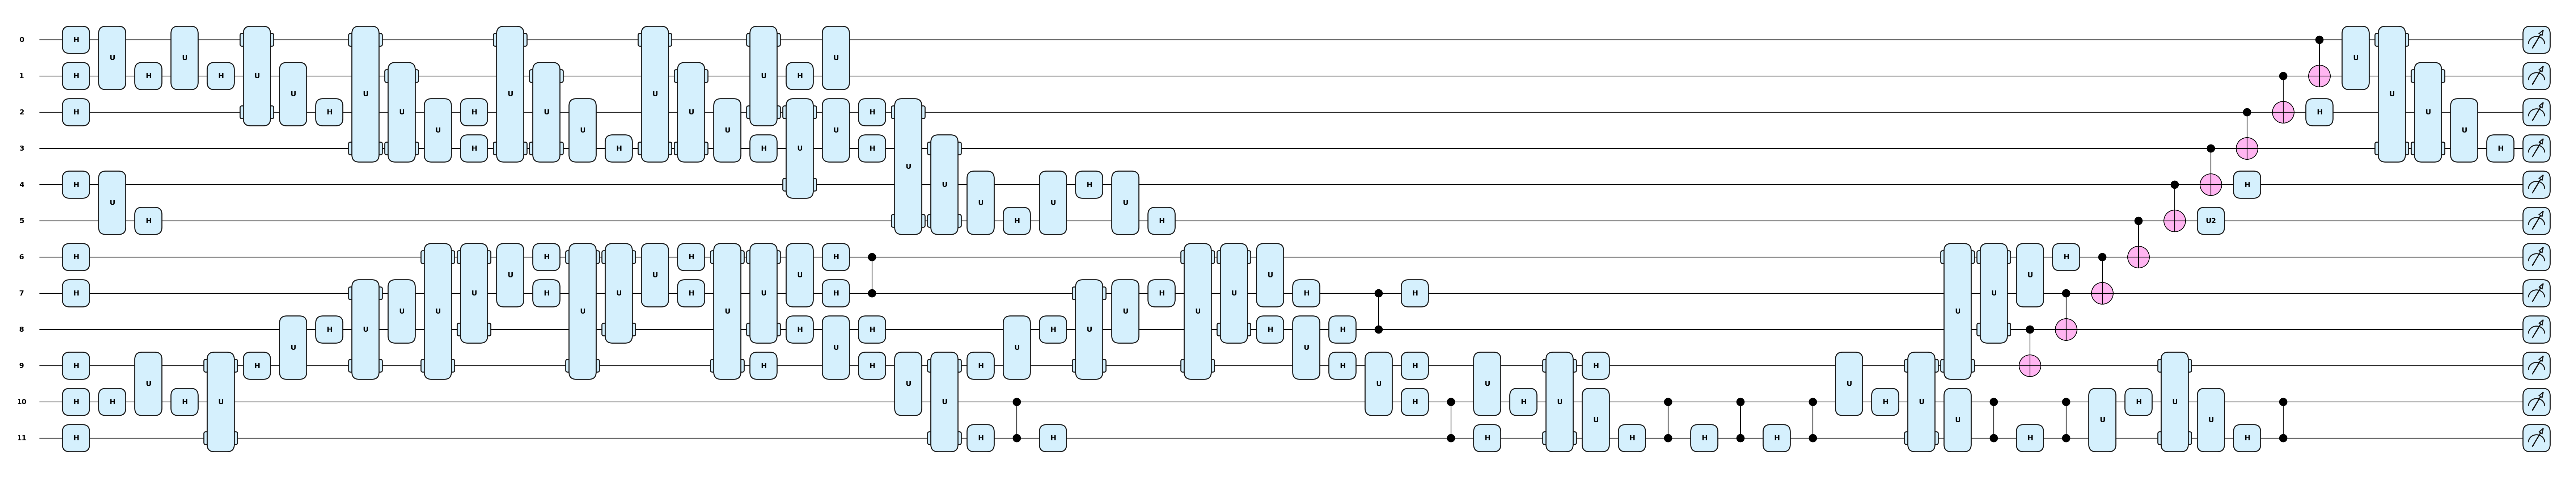

In [183]:
transpiled_penny = compile(circuit)
qml.draw_mpl(transpiled_penny, style='pennylane')()
plt.show()

In [184]:
transpiled_penny()

array([ 0.01990025-0.01800414j,  0.00255374+0.00622259j,
        0.00609409+0.00248924j, ..., -0.00024973+0.00113265j,
       -0.00149343-0.00289479j, -0.00123588+0.00200629j])

In [189]:
def summary_penny(circuit):
    obj = qml.specs(circuit)()['resources']
    return [obj.num_wires, obj.num_gates, obj.gate_sizes[1], obj.gate_sizes[2], obj.depth]
    
summary_penny(circuit)

[13, 205, 116, 89, 72]

In [79]:
summary_penny(transpiled_penny)

[4, 9, 5, 4, 4]

In [ ]:
# Transpile with qiskit
qc.save_statevector()
backend = Aer.get_backend('qasm_simulator')
transpiled_qiskit_2 = transpile(qc, backend)
result_2 = backend.run(transpiled_qiskit_2).result()
qiskit_2_state = result_2.get_statevector()
print(qiskit_2_state)

In [93]:
df = pd.DataFrame(columns=['original','qiskit_2','qiskit_3','penny'])
df['original'] = summary_qiskit(qc)
df['qiskit_2'] = summary_qiskit(transpiled_qiskit_2)
df['qiskit_3'] = summary_qiskit(transpiled_qiskit_3)
df['penny'] = summary_penny(transpiled_penny)
df.index = ['qubits', 'gates', '1q gates', '2q gates', 'depth', 'fidelity']
df

,original,qiskit_2,qiskit_3,penny
qubits,4,4,4,4
gates,16,11,9,9
1q gates,6,1,1,5
2q gates,6,6,4,4
depth,9,7,4,4


In [193]:
df['penny'].iloc[-1]

4

In [203]:
def qiskit_transpiler(qc, level=2):
    # Transpile with qiskit
    qc.save_statevector()
    backend = Aer.get_backend('qasm_simulator')
    transpiled_qiskit = transpile(qc, backend, optimization_level=level)
    result = backend.run(transpiled_qiskit).result()
    transpiled_state = result.get_statevector()
    return transpiled_qiskit, transpiled_state

def penny_tranpiler(qc):
    pc_penny = qml.from_qiskit(qc)
    num_q = qc.num_qubits
    dev = qml.device("default.qubit", wires=num_q)
    
    @qml.qnode(dev)
    def circuit():
        pc_penny(wires=range(num_q))
        return qml.state()
    
    transpiled_penny = compile(circuit)
    return transpiled_penny, transpiled_penny()

In [209]:
def make_table(qc):
    df = pd.DataFrame(columns=['original','qiskit_2','qiskit_3','penny'])
    df['original'] = summary_qiskit(qc)
    ref_state = Statevector(qc)
    # code to get the ranspiled circuits
    transpiled_qiskit_2, state_2 = qiskit_transpiler(qc,2)
    df['qiskit_2'] = summary_qiskit(transpiled_qiskit_2)
    transpiled_qiskit_3, state_3 = qiskit_transpiler(qc,3)
    df['qiskit_3'] = summary_qiskit(transpiled_qiskit_3)
    transpiled_penny, state_p = penny_tranpiler(qc)
    df['penny'] = summary_penny(transpiled_penny)
    df.index = ['qubits', 'gates', '1q gates', '2q gates', 'depth', 'fidelity']
    df.loc['fidelity'] = ['',state_fidelity(ref_state,state_2),state_fidelity(ref_state,state_3),fidelity_penny(ref_state,state_p)]
    print(df)

In [210]:
make_table(qc)

QiskitError: 'You have to select a circuit or schedule when there is more than one available'

In [196]:
# test with a sample form ketgpt
# Mapping from PennyLane to Qiskit
[ds] = qml.data.load("ketgpt")
@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 999
    for op in ds.circuits[0]:
        qml.apply(op)
    return qml.state()

In [197]:
sample_q_num = qml.specs(circuit)()['resources'].num_wires

In [198]:
gate_name = []
gate_info = []
for op in ds.circuits[0]:
    name = op.name
    gate_name.append(name)
    wires = [int(w) for w in op.wires]
    params = op.parameters
    gate_info.append({
        "name": name,
        "wires": wires,
        "params": params,
    })
gate_info[:3]

[{'name': 'Hadamard', 'wires': [0], 'params': []},
 {'name': 'Hadamard', 'wires': [1], 'params': []},
 {'name': 'Hadamard', 'wires': [2], 'params': []}]

In [199]:
def to_qiskit(dict_elem):
    name = dict_elem['name']
    wire = dict_elem['wires']
    param = dict_elem['params']
    if name == 'Hadamard':
        qc.h(wire[0])
    if name == 'PauliX':
        qc.x(wire[0])
    if name == 'PauliY':
        qc.y(wire[0])
    if name == 'PauliZ':
        qc.z(wire[0])
    if name == 'CNOT':
        qc.cx(wire[0],wire[1])
    if name == 'CX':
        qc.cx(wire[0],wire[1])  
    if name == 'CY':
        qc.cy(wire[0],wire[1])  
    if name == 'CZ':
        qc.cz(wire[0],wire[1])    
    if name == 'QubitUnitary':
        qc.append(UnitaryGate(param[0]),wire)
    if name == 'U2':
        qc.u(pi/2, param[0], param[1], wire[0])

In [200]:
gate_info[0]['name']

'Hadamard'

In [201]:
# Create a bloated circuit with 4 qubits
qc = QuantumCircuit(sample_q_num)
for dict_elem in gate_info:
    to_qiskit(dict_elem)
qc.measure_all()

In [202]:
make_table(qc)

          original  qiskit_2  qiskit_3  penny
qubits          13         4         4     12
gates          218         7         5    147
1q gates       116         1         1     64
2q gates        89         6         4     83
depth           73         6         3     60
